# Controlling a BLDC Motor with Q-Learning

<b>Goal:</b> Drive BLDC motor smoothly to a target angle.

<b>Plan:</b> Train Q-Learning to learn stator configurations that lead to maximum change in velocity (spin the motor). 

<b>Implementation:</b> Simulate simplified motor with angle and angular velocity. Stator poles push and pull rotor poles causing the rotor to spin.

<b>Result:</b> Q values are learned to spin the motor in one direction. To rotate the other way, we choose the lowest Q value. We can then drive the motor in any direction we want. 

In [ ]:
import itertools
from collections import defaultdict 
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
from IPython.display import clear_output
import cv2
import imutils

%matplotlib inline

In [ ]:
class Magnet(object):
    redCoil = cv2.imread('simulation/red.png')
    blueCoil = cv2.imread('simulation/blue.png')
    neutralCoil = cv2.imread('simulation/neutral.png')
    rotorRed = cv2.imread('simulation/rotorRed.png')
    rotorBlue = cv2.imread('simulation/rotorBlue.png')
        
    def __init__(self, theta_init, radius, charge, electric=False, name=None):
        self.theta_init = theta_init
        self.radius = radius
        self.charge = charge
        self.theta = 0
        self.updateP()
        self.name = name
        self.electric = electric
        
    def updateP(self):
        self.p = self.pos()
    
    def pos(self, radiusOffset=0):
        t = self.theta_init+self.theta
        r = self.radius+radiusOffset
        return np.array([np.cos(t) * r, -np.sin(t) * r])
    
    def force(self, stator_magnet):
        # self is in the rotor
        # stator_magnet is magnet in stator
        charge = self.charge * stator_magnet.charge
        
        R = self.p
        R = R / np.linalg.norm(R)
        
        F = stator_magnet.p - self.p
        F_norm = np.linalg.norm(F)
        F /= F_norm
        
        force = 20 * charge * np.cross(R, F) / (F_norm ** 2)
        return force
    
    def render(self, img):
        p = self.pos()
        t = self.theta_init + self.theta
        
        height, width, _ = img.shape        
        
        graphic = None
        if self.electric:
            if self.charge > 0:
                graphic = Magnet.redCoil
            elif self.charge < 0:
                graphic = Magnet.blueCoil
            else:
                graphic = Magnet.neutralCoil
        else:
            if self.charge > 0:
                graphic = Magnet.rotorRed
            elif self.charge < 0:
                graphic = Magnet.rotorBlue
                
        graphic = imutils.rotate(graphic, t * 180 / np.pi)
        px, py = int(p[0]+width/2-50), int(p[1]+height/2-50)
        img[py:py+100, px:px+100] += graphic
        
        if self.name:
            p2 = self.pos(10)
            label = np.zeros((40, 40, 3), dtype=np.uint8)
            label = cv2.putText(label, self.name, (5, 35), 
                              cv2.FONT_HERSHEY_SIMPLEX,  
                               1, (255, 255, 255), 2, cv2.LINE_AA)
            lp = (int(p2[0]+width/2 - 15), int(p2[1]+height/2 - 25))
            img[lp[1]:lp[1]+40, lp[0]:lp[0]+40, :] += label
            img = np.clip(img, 0, 255)
        return img

class Motor(object):
    def __init__(self, stator_radius,
                       rotor_radius,
                       decay,
                       rotor_num,
                       stator_num):
        self.stator_radius = stator_radius
        self.rotor_radius = rotor_radius
        self.decay = decay
        self.rotor_num = rotor_num
        self.stator_num = stator_num
        
        self.theta = 0
        self.vel = 0
        self.target_angle = 0
        
        charge_fn = lambda i: 1 if i%2 == 0 else -1
        
        stator_names = ["A", "B", "C"]
        
        self.rotor = [Magnet(i * 2 * np.pi / rotor_num, rotor_radius, -1 * charge_fn(i), False)
                      for i in range(rotor_num)]
        self.stator = [Magnet(i * 2 * np.pi / stator_num, stator_radius, charge_fn(i), True, 
                              stator_names[i%len(stator_names)]) for i in range(stator_num)]
        
        # For rendering
        self.width, self.height = (400, 400)
                
    def step(self, stator_state, steps, render=False):
        theta_init = self.theta
        vel_init = self.vel
        
        for i in range(steps):
            
            for j in range(len(self.stator)):
                s = self.stator[j].charge = stator_state[j%len(stator_state)]
            #for s, charge in zip(self.stator, stator_state):
            #    s.charge = charge
            
            for r in self.rotor:
                r.theta = self.theta
                r.updateP()
                for s in self.stator:
                    force = r.force(s)
                    self.vel += force
            self.theta += self.vel
            self.vel *= self.decay
            
            if render: self.render()
                    
        dtheta = self.theta - theta_init
        dvel = self.vel - vel_init
        return (dtheta, dvel)
    
    def rotated(self, angle, offset):
        return (int(self.height/2 + offset * np.cos(angle)), 
                    int(self.width/2 - offset * np.sin(angle)))
    
    def render(self, Qrender = None):        
        img = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        
        cv2.circle(img, (int(self.height/2), int(self.width/2)), 
                   self.rotor_radius + 15, (126,126,126), 3)
                
        # draw the angle of the motor
        p1 = self.rotated(self.theta, self.rotor_radius + 30)
        p2 = self.rotated(self.theta, self.rotor_radius + 50)
        cv2.line(img, p1, p2, (255, 255, 255), 2)
        
        if self.target_angle:
            t1 = self.rotated(self.target_angle, self.rotor_radius + 30)
            t2 = self.rotated(self.target_angle, self.rotor_radius + 50)
            cv2.line(img, t1, t2, (0, 255, 0), 2)
        
        for s in self.stator:
            img = s.render(img)
            
        for r in self.rotor:
            img = r.render(img)
            
        # render Q values too.. why not :-)
        if Qrender:
            l = 10
            for i, state in enumerate(Qrender):
                Qs = Qrender[state]
                for j in range(len(Qs)):
                    c = 127 + int(Qs[j] * 1000)
                    c = max(min(255, c), 0)
                    cv2.rectangle(img, (j * l, i * l), (j * l + l, i * l + l), (c, c, c), -1)
            
        cv2.imshow("BLDC", img)
        cv2.waitKey(1)

# Possible Phases for 3 Stator Magnet

<img src="diagram/stator.png" width=600 align="left">

In [ ]:
# Stator configurations for A B C, -1 is "south", 0 is neutral and 1 is "north".
states = [[1, 0, -1],
          [0, 1, -1],
          [-1, 1, 0],
          [-1, 0, 1],
          [0, -1, 1],
          [1, -1, 0]]

# The angle the corresponding state above causes the rotor to align to. 
state_angles = [np.pi * 1 / 6,
              np.pi * 3 / 6,
              np.pi * 5 / 6,
              np.pi * 7 / 6,
              np.pi * 9 / 6,
              np.pi * 11 / 6]

motor = Motor(stator_radius=60,
              rotor_radius=120,
              decay=0.94,
              rotor_num=2,
              stator_num=3
             )

In [ ]:
# 30 degrees alignment
motor.theta = state_angles[0]
motor.target_angle = state_angles[0]
_, _ = motor.step(states[0], 100, True)

In [ ]:
# 90 degrees alignment
motor.target_angle = state_angles[1]
_, _ = motor.step(states[1], 100, True)

In [ ]:
# 150 degrees alignment
motor.target_angle = state_angles[2]
_, _ = motor.step(states[2], 100, True)

In [ ]:
# 210 degrees alignment
motor.target_angle = state_angles[3]
_, _ = motor.step(states[3], 100, True)

In [ ]:
# 270 degrees alignment
motor.target_angle = state_angles[4]
_, _ = motor.step(states[4], 100, True)

In [ ]:
# 330 degrees alignment
motor.target_angle = state_angles[5]
_, _ = motor.step(states[5], 100, True)

In [ ]:
for s, a in zip(states, state_angles):
    motor.target_angle = a
    motor.step(s, 50, True)

In [ ]:
# We can speed it up to get the motor to spin
# and not "cog" to each position. 

for i in range(20):
    motor.target_angle = state_angles[i%6]
    motor.step(states[i%6], 28, True)

In [ ]:
# Reverse the order reverses the motor

for i in reversed(range(20)):
    motor.target_angle = state_angles[i%6]
    motor.step(states[i%6], 28, True)

In [ ]:
# Try to reach an angle by driving forward or backward
# This is open loop motor control as we don't use
# the rotor position to inform what stator configuration we should use. 

def minAngle(x, y):
    tau = 2*np.pi
    a = (x - y) % tau
    b = (y - x) % tau
    return -a if a < b else b

motor.theta = 0
motor.target_angle = np.random.random() * 2 * np.pi

i = 0
for _ in range(20):
    if minAngle(motor.theta, motor.target_angle) > 0:
        i += 1
    else:
        i -= 1
    
    motor.step(states[i%6], 40, True)

In [ ]:
# We can also try to interpolate between stator configurations
# to achieve a midpoint (or ratio) between their resulting angles.
# This proves the motor can rotate slowly even with very
# few stator magnets. 

def averageState(state0, state1, ratio):
    motor.target_angle = state_angles[state0]
    _, _ = motor.step(states[state0], int(4 * (1-ratio)), True)

    motor.target_angle = state_angles[state1]
    _, _ = motor.step(states[state1], int(4 * ratio), True)
        
for _ in range(40):
    averageState(0, 1, .5)

# Q Learning Training

TD update code: https://www.geeksforgeeks.org/q-learning-in-python/

Here we create an environment which consists of our motor simulation. 
Q-learning then reads the environment state (the motor angle) and then
provides an action (stator configuration) back to the env. 
The env then simulates that action and reports the change in motor velocity.
Q-learning can eventually learn how the motor will respond in at any angle
to any stator configuration. 

In [100]:
class MotorEnv():
    def __init__(self):
        self.motor = Motor(stator_radius=60,
              rotor_radius=120,
              decay=0.94,
              rotor_num=2,
              stator_num=3
             )
        
        # The number of actions = the number of stator configurations
        self.actions = len(states)
        
        self.episode_steps = 100
        self.steps = 0
        
        self.render = False

    def states(self):
        # The size of the state of the environment, one number (the rotor angle)
        return dict(type='float', shape=(1,))
    
    def getState(self):
        t1 = self.motor.theta
        # Discretize the motor angle into N buckets as otherwise
        # it can take on an infinite number of values and our system
        # will never generalize. 
        N = 20
        motor_angle = (np.round(t1 % (2 * np.pi) / (2 * np.pi) * N) / N)
        return (motor_angle)

    def reset(self):
        # Reset the motor for a new training episode
        # choose a random angle and also random velocity
        # so the motor is robust regardless of its original velocity
        # going into the action. 
        self.steps = 0
        self.motor.theta = np.random.random() * 2 * np.pi - np.pi
        self.motor.vel = np.random.randn() * .01
        return self.getState()

    def step(self, action):
        # Get the stator configuration given the action
        stator_config = states[action]
        
        # Simulate the motor for one time step
        dtheta, dvel = self.motor.step(stator_config, 1, self.render)
        
        # Record the reward as the change in angular velocity
        # scale it cause... it's tiny otherwise? :o) 
        reward = dvel * 10
        
        # Check if episode is over
        self.steps += 1
        terminal = True if self.steps >= self.episode_steps else False
        
        # Return the new state, reward, and whether the episode should
        # terminate. 
        return self.getState(), reward, terminal

def createPolicy(Q, epsilon, num_actions):
    """
    Creates epsilon greedy policy. 
    
    Starts all actions at epsilon/num_actions probability
    and adds 1-epsilon to the best action.
    Note the probabilities sum to one.
    
    If epsilon is 0, the best action will have probability 1,
    this is no exploration and full exploitation. 
    
    If epsilon is 1, then all actions will be equally likely,
    this is full exploration and no exploitation. 
    """
    def policy(state): 
        probs = np.ones(num_actions, dtype = float) * epsilon / num_actions
        best_action = np.argmax(Q[state]) 
        probs[best_action] += (1.0 - epsilon) 
        return probs
    
    return policy

def qLearning(env, Q, num_episodes, episode_steps, discount_factor=0.9, 
                            alpha=0.3, epsilon=0.1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy.
    
    discount_factor is how much we discount the value of resulting states
    when updating the current state.
    
    alpha is the learning rate, or how quickly we change Q values.
    
    epsilon is how much we explore. epsilon = 0 means no exploration. 
    """
    
    env.render = False
    env.episode_steps = episode_steps

    rewards = []

    policy = createPolicy(Q, epsilon, env.actions)
       
    for ith_episode in range(num_episodes): 
        
        state = env.reset()
        avg_reward = 0
        
        for t in itertools.count():
            action_probs = policy(state)
   
            action = np.random.choice(np.arange( 
                      len(action_probs)), 
                       p = action_probs)
   
            next_state, reward, done = env.step(action)
   
            avg_reward += reward
               
            # TD Update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
               
            # done is True if episode terminated    
            if done:
                break
                   
            state = next_state
            
        avg_reward /= 1 if t == 0 else t
        rewards += [avg_reward]
        
        motor.render(Q)
        
        # print Q values
        if ith_episode % 50 == 0:
            clear_output(wait=True)
            #print("episode: ", ith_episode)
            #for state in Q:
            #    fig = plt.plot(Q[state])
                
            plt.plot(rewards)
            plt.show()
       
    return Q, rewards


env = MotorEnv()
Q = defaultdict(lambda: np.zeros(env.actions))

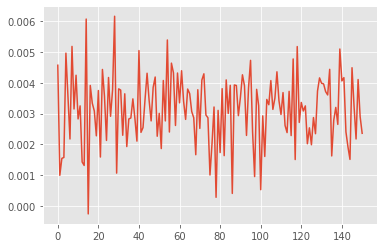

In [101]:
# Train
Q, rewards = qLearning(env, Q, 200, 100, discount_factor=0.2, alpha=0.05, epsilon=0.2)

In [103]:
Q[0.0]

array([-0.00351944,  0.00616073,  0.00056083, -0.01221088, -0.01899141,
       -0.01171829])

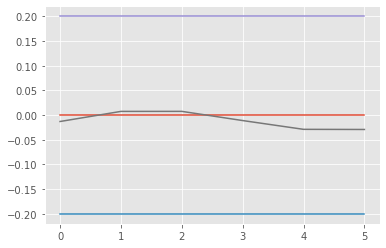

In [106]:
for state in Q:
    clear_output(wait=True)
    plt.plot([0, 5], [0, 0])
    plt.plot([0, 5], [-.2, -.2])
    plt.plot([0, 5], [.2, .2])
    fig = plt.plot(Q[state])
    plt.show()

In [108]:
# Evaluate the best actions

def evaluate(env, Q, num_episodes, episode_steps): 
    
    env.motor.target_angle = None
    env.render = True
    env.episode_steps = episode_steps
    env.motor.decay = 0.95
    
    rewards = []
    
    targ = 0
    
    for ith_episode in range(num_episodes):
        
        state = env.reset()
        
        
        for t in itertools.count():
            action = np.argmax(Q[state])
   
            next_state, reward, done = env.step(action) 
            rewards += [reward]
            
            if done:
                break
                   
            state = next_state
       
    return rewards
rewards = evaluate(env, Q, 1, 300)
#plt.plot(rewards)

In [110]:
# Evaluate the worse actions!

def evaluate(env, Q, num_episodes, episode_steps): 
    
    env.motor.target_angle = None
    env.render = True
    env.episode_steps = episode_steps
    env.motor.decay = 0.95
    
    rewards = []
    
    targ = 0
    
    for ith_episode in range(num_episodes):
        
        state = env.reset()
        
        
        for t in itertools.count():
            action = np.argmin(Q[state])
   
            next_state, reward, done = env.step(action) 
            rewards += [reward]
            
            if done:
                break
                   
            state = next_state
       
    return rewards

rewards = evaluate(env, Q, 1, 300)
#plt.plot(rewards)

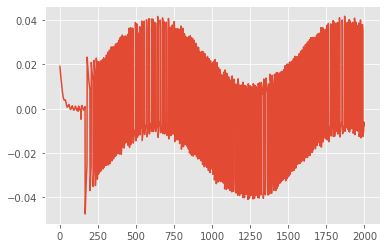

In [111]:
# Seek the target

def evaluate(env, Q, num_episodes, episode_steps): 
    
    env.render = True
    env.episode_steps = episode_steps
    env.motor.decay = 0.95
    
    rewards = []
    
    targ = 0
    
    for ith_episode in range(num_episodes):
        
        state = env.reset()
        env.motor.target_angle = np.random.random() * 2 * np.pi
        
        for t in itertools.count():
            targ += 0.005
            env.motor.target_angle = np.sin(targ) * 2 * np.pi
            
            if np.sign(minAngle(env.motor.theta, env.motor.target_angle)) == 1:
                action = np.argmax(Q[state])
            else:
                action = np.argmin(Q[state])
   
            next_state, reward, done = env.step(action) 
            rewards += [reward]
            
            if done:
                break
                   
            state = next_state
       
    return rewards

rewards = evaluate(env, Q, 1, 2000)
plt.plot(rewards)

# Failed Training Attempts:

# Evolution Strategies Training

In [ ]:
def state(motor):
    return motor.theta % (2 * np.pi)

def stator_state(W, motor):
    t = state(motor)
    stators = motor.stator_num
    stator_state = np.zeros((stators))
    frac = 1 / stators
    for i, r in enumerate(W):
        stator_state[i] = frac * np.sin(t*r[0] + r[1])
    return stator_state

def plot_stator_state(W):
    for stator in range(W.shape[0]):
        pts = []
        for t in np.linspace(0, 2 * np.pi, 50)[:-1]:
            motor.theta = t
            pts += [[t, stator_state(W, motor)[stator]]]

        pts = np.array(pts)
        fig = plt.plot(pts[:,0], pts[:,1])

In [ ]:
motor = Motor(stator_radius=120,
              rotor_radius=80,
              decay=0.995,
              rotor_num=2,
              stator_num=3
             )

W = np.random.randn(motor.stator_num, 2) # stators x 2 params each

plot_stator_state(W)

In [ ]:
avg_dvels = []

# train
for i in range(1000):
    if i % 100 == 0:
        clear_output(wait=True)
        print(i)
        #plt.plot(avg_dvels)
        plot_stator_state(W)
        plt.show()
    
    theta_init = np.random.random() * 2 * np.pi
    vel_init = np.random.randn() * .01
    
    motor.theta = theta_init
    motor.vel = vel_init
    _, _, _, dvel_init = motor.step(stator_state(W, motor), 1, False)
    
    avg_dvels += [dvel_init]
    
    W_update = np.zeros_like(W)
    
    for j in range(50):
        Wd = np.random.randn(W.shape[0], W.shape[1])
        bd = np.random.randn(b.shape[0])
        motor.theta = theta_init
        motor.vel = vel_init
        _, _, dtheta, dvel = motor.step(stator_state(W+Wd,
                                                     motor), 1, False)
        
        W_update += Wd * (dvel - dvel_init)
    
    W += 1 * W_update

In [ ]:
# evaluate
for k in range(1):
    theta_init = np.random.random() * 2 * np.pi
    vel_init = 0
    motor.theta = theta_init
    motor.vel = vel_init

    for i in range(1000):
        _, _, _, dvel_init = motor.step(stator_state(w, motor), 1, True)

# Pick the best weights Training

In [ ]:
best_dvel = 0
best_W = np.random.randn(motor.stator_num, 2)
dvels = []

In [ ]:
for i in range(1000):
    W = 2 * np.random.randn(best_W.shape[0], best_W.shape[1])
    
    avg_dvel = 0
    
    for j in range(10):
        motor.theta = np.random.random() * 2 * np.pi
        motor.vel = 0 #np.random.randn() * .1
        _, _, _, dvel = motor.step(stator_state(W, motor), 10, False)
        avg_dvel += dvel
    
    if avg_dvel > best_dvel:
        print("new best: ", avg_dvel)
        best_dvel = avg_dvel
        best_W = W
        dvels += [avg_dvel]
        
        clear_output(wait=True)
        #print(i)
        plot_stator_state(W)
        plt.show()

In [ ]:
# evaluate
for k in range(1):
    theta_init = np.random.random() * 2 * np.pi
    vel_init = 0
    motor.theta = theta_init
    motor.vel = vel_init

    for i in range(10000):
        _, _, _, dvel_init = motor.step(stator_state(best_W, motor), 1, True)

# Training

source: https://tensorforce.readthedocs.io/en/latest/basics/getting-started.html

In [ ]:
from tensorforce.environments import Environment
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from IPython.display import clear_output

In [ ]:
class MotorEnv(Environment):
    def __init__(self):
        super().__init__()
        self.motor = Motor(stator_radius=120,
                  rotor_radius=80,
                  decay=0.995,
                  rotor_num=2,
                  stator_num=3
                 )
        self.num_actions = 6
        self.render = False
        self.episode_steps = 100

    def states(self):
        return dict(type='float', shape=(1,))

    def actions(self):
        return dict(type='int', num_values=6)
    
    # Optional
    def close(self):
        super().close()

    def reset(self):
        self.motor.theta = np.random.random() * 2 * np.pi - np.pi
        self.motor.vel = np.random.randn() * .05
        self.motor.steps = 0
        return np.array([self.motor.theta % 2*np.pi])

    def execute(self, actions):
        stator_num = self.motor.stator_num
        
        motor_states = states[actions]
        thetas, vels, dtheta, dvel = self.motor.step(motor_states, 10, self.render)
        next_state = np.array([self.motor.theta % 2*np.pi])
        
        self.motor.steps += 1
        terminal = True if self.motor.steps >= self.episode_steps else False
        reward = dvel * 10 #-np.abs(self.motor.theta)
        return next_state, terminal, reward
    
env = MotorEnv()

#agent = Agent.create(
#    agent='ppo', environment=env, batch_size=10, learning_rate=1e-3, max_episode_timesteps=1
#)

agent = Agent.create(
    agent='tensorforce', environment=env, update=64,
    objective='policy_gradient', reward_estimation=dict(horizon=20),
    max_episode_timesteps=100, exploration=.2
)

runner = Runner(
    agent=agent,
    environment=env
)

clear_output(wait=True)
env.episode_steps = 5
runner.run(num_episodes=100)

In [ ]:
env.render = True
env.episode_steps = 10
runner.run(num_episodes=10, evaluation=True)

In [ ]:
runner.close()

In [ ]:
t = np.linspace(-2*np.pi, 4 * np.pi, 200)
t = t % (2*np.pi)
t2 = [np.digitize(h, np.linspace(0, 2*np.pi, 10)) for h in t]
t2 /= np.max(t2)
t2 *= 2*np.pi
fig = plt.plot(t)
fig = plt.plot(t2)